In [2]:
import re
import os
import io
import ast
import gzip
import glob

import numpy as np
import pandas as pd

import torch
import pyro.distributions as dist

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

from path import Path

from tqdm.notebook import tqdm

In [35]:
latent_dim_dict = {'Arizona': 5, 'Atlanta':7 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinnati':13, 'Cleveland':11, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':10, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 12, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':4}
grouped_df = pd.read_csv('Grouped_df.csv')
zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

# results_dir = Path('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/')
results_dir = Path('.')
posterior_samples = torch.load(results_dir.joinpath('GAP_posterior_samples_None_01_latent_dim_5.pth'))
Z_samples = np.array(posterior_samples['Z'])
latent_dim, n_counties = Z_samples[0].shape

team = 'Indianapolis'
data_dir = Path(f'dat/{team}')

train_pivot = pd.read_csv(data_dir.joinpath('train_pivot.csv'), index_col=0)
test_pivot = pd.read_csv(data_dir.joinpath('test_pivot.csv'), index_col=0)

train_data = train_pivot.values
test_data = test_pivot.values
assert train_data.shape[1] == test_data.shape[1] == n_counties

train_dates = train_pivot.index
test_dates = test_pivot.index

total_pivot = pd.concat([train_pivot, test_pivot], axis=0)
total_data = outcomes = total_pivot.values
intervention_day = train_data.shape[0]

assert np.allclose(outcomes[intervention_day:], test_data)

rbsc_pred = torch.load(f"RBSC_Replications/{team}/train_data.pt")
rbsc_test_pred = rbsc_pred[intervention_day:]

In [65]:
def get_reg_arrays(Z, outcomes, intervention_day, counterfactual=False, include_previous_outcome=False):
    latent_dim, n_counties = Z.shape
    assert outcomes.shape[0] == n_counties

    A = np.zeros((n_counties, 1))
    if not counterfactual:
        A[-1] = 1
    
    if include_previous_outcome:
        # Y_{i,t} ~ A + Z_i + Y_{i,-1} 

        B = np.array(outcomes[:, intervention_day-1])[:, np.newaxis]
        X = np.concatenate([Z.T, B, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 2)
    else:
        X = np.concatenate([Z.T, A], axis=1)
        assert X.shape == (n_counties, latent_dim + 1)

    Y = np.array(outcomes[:, intervention_day:])
    return X, Y


def get_counterfactual_from_best_reg(Z, outcomes, intervention_day, include_previous_outcome=True,
                                     reg_type='Ridge', reg_params={"alpha": [0, 1e-4,1e-3, 1e-2]}):
    
    X, Y = get_reg_arrays(Z, outcomes, intervention_day, include_previous_outcome=include_previous_outcome)

    if reg_type == 'Ridge':
        reg = Ridge()
    elif reg_type == 'MLP': 
        reg = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
    elif reg_type == 'Lasso':
        reg = Lasso()
    
    cv = GridSearchCV(reg, reg_params, scoring='r2', cv=5)
    cv_results = cv.fit(X, Y)
    best_reg = cv_results.best_estimator_

    X, _ = get_reg_arrays(Z, outcomes, intervention_day, include_previous_outcome=include_previous_outcome, counterfactual=True)
    return best_reg.predict(X)[-1], best_reg  # return only affected county and model

cf_preds = []
for Z in tqdm(Z_samples):
    cf_pred, _ = get_counterfactual_from_best_reg(Z,
                                                  reg_type='Ridge',
                                                  outcomes=outcomes.T, 
                                                  intervention_day=intervention_day, 
                                                  include_previous_outcome=True)
    cf_preds.append(cf_pred)
cf_preds = np.array(cf_preds)

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/aaronschein/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/aaronschein/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/aaronschein/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.803e+04, tolerance: 5.644e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in 

KeyboardInterrupt: 

[Timestamp('2020-03-06 00:00:00'),
 Timestamp('2020-03-07 00:00:00'),
 Timestamp('2020-03-08 00:00:00'),
 Timestamp('2020-03-09 00:00:00'),
 Timestamp('2020-03-10 00:00:00'),
 Timestamp('2020-03-11 00:00:00'),
 Timestamp('2020-03-12 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-14 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-17 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-03-29 00:00:00'),
 Timestamp('2020-03-30 00:00:00'),
 Timestamp('2020-03-31 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-04-02 00:00:00'),
 Timestamp('2020-04-

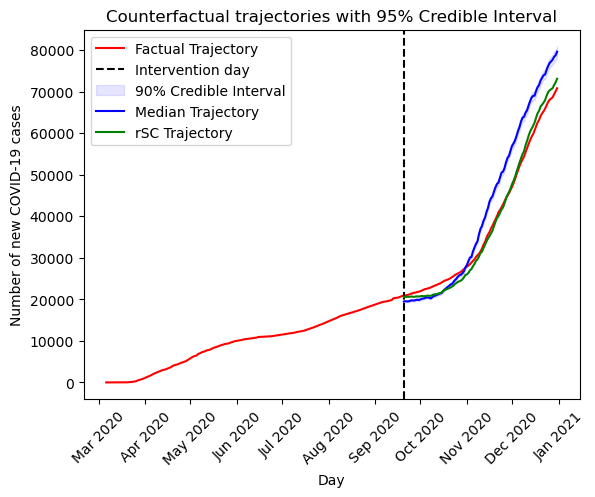

In [64]:
pre_intervention_outcomes = outcomes[:intervention_day, -1]

# Compute percentiles and median across trajectories for each time point
lower_bound = np.percentile(cf_preds, 5, axis=0)
upper_bound = np.percentile(cf_preds, 95, axis=0)
median_trajectory = np.median(cf_preds, axis=0)

dates = pd.to_datetime(total_pivot.index)
plt.plot(dates, outcomes[:, -1], 'r-', label='Factual Trajectory')
plt.axvline(dates[intervention_day], color='k', linestyle='--', label='Intervention day')

post_dates = dates[intervention_day:]
plt.fill_between(post_dates, lower_bound, upper_bound, color='blue', alpha=0.1, label='90% Credible Interval')
plt.plot(post_dates, median_trajectory, 'b-', label='Median Trajectory')
plt.plot(post_dates, rbsc_test_pred, 'g-', label='rSC Trajectory')
plt.legend()
plt.title('Counterfactual trajectories with 95% Credible Interval')
plt.xlabel('Day')

import matplotlib.dates as mdates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Every month
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Month and year
plt.xticks(rotation=45)

plt.ylabel('Number of new COVID-19 cases')
plt.show()



In [57]:
pd.to_datetime(test_pivot.index)

DatetimeIndex(['2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24', '2020-09-25', '2020-09-26', '2020-09-27',
               '2020-09-28', '2020-09-29',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=103, freq=None)

In [44]:
counterfactual_x = x_regressors
counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.

if regression_type == 'MLP':
    counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
elif regression_type in ['Ridge', 'Lasso']:
    coefficients = torch.tensor(deconfound_lin_reg.coef_)

    assert coefficients.shape[1] == latent_dim + 1
    assert coefficients.shape[0] == post_intervention_days


    #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
    #stadium county .

    #coefficients = coefficients.float()

    counterfactual_outcome = counterfactual_x @ coefficients.clone().detach().transpose(0, 1)

assert counterfactual_outcome.shape == Y.transpose(0,1).shape
counterfactual_outcomes_deconfound.append(counterfactual_outcome)

Ridge(alpha=0.01)

In [23]:
def synthetic_control(Z_samples, train_data, test_data, dates):
    n_pre_intervention_days, n_counties = train_data.shape
    n_post_intervention_days, n_counties = test_data.shape

    latent_dim = Z_samples[0].shape[0]
    assert Z_samples[0].shape == (latent_dim, n_counties)
    
    #Store results for different synthetic control regressions, as we iterate through W_samples
    counterfactual_outcomes_deconfound = []
    time_step_outcomes = []

    A = np.zeros(n_counties)
    A[-1] = 1
    A = A.reshape(1, n_counties) # why?
    
    for Z_sample in Z_samples: 
    
        #Run Regression with latent_p W_sample on Y_it, for each timestep t post intervention. 
        
        #Add [1] if it is intervention
        
        #Serialize the arrays for the plots. Save to disk the files. 
        #An array that is RBSC, array that is 2000 trajectories, array that is test data, k=9, etc etc etc, actual posterior samples used
        #Create folder called replication. Some files for every county. all 2000 posterior, RBSC predictions. counterfactual. 
        #Within each county, another subfolder that for GAP, PPCA, k_5, k_10

        #After folders, create jupyter notebook that goes through the directories, pulls through right arrays, then calculates causal effects.
        #FLAG use this model for this county. 

        #ATT results. 

            
        x_regressors = torch.cat((W_sample, A), dim=0).transpose(0,1)
        
        assert x_regressors.shape == (w_counties, latent_dim + 1)

        #For Yit ~ Ai + Yi(-m) + … + Yi(-1), ,we need stadium data pre intervention, which is just stadium train

        Y = test_data

        assert Y.shape == (post_intervention_days,  w_counties)

        test_data_array = np.array(test_data)
        stadium_test = test_data_array[:, -1]
        train_data_array = np.array(train_data)
        stadium_train = train_data_array[:, -1]

        #Try Ridge, Lasso, MLP Regression ,with Cross Validation to find best value. 
        
        #Parameters for GridsearchCV for Lasso and Ridge
        parameters = {"alpha": [0, 1e-4,1e-3, 1e-2]}
        if regression_type == 'Ridge':
            reg = Ridge()
            clf = GridSearchCV(reg, parameters, scoring='r2', cv=5)
        elif regression_type == 'MLP': 
            clf = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=5000)
        elif regression_type == 'Lasso':
            reg = Lasso()
            #parameters = {'alpha': [0.01]}
            #Right now 0.01 working best for lasso
            clf = GridSearchCV(reg, parameters, scoring = 'r2', cv=5)
            
        deconfound_lin_reg = clf.fit(x_regressors, Y.transpose(0,1))
        deconfound_lin_reg = clf.best_estimator_
        
        counterfactual_x = x_regressors
        counterfactual_x[w_counties-1, latent_dim] = 0 #Set "stadium open status" to 0.
        
        if regression_type == 'MLP':
            counterfactual_outcome = deconfound_lin_reg.predict(counterfactual_x)
        elif regression_type in ['Ridge', 'Lasso']:
            coefficients = torch.tensor(deconfound_lin_reg.coef_)
        
            assert coefficients.shape[1] == latent_dim + 1
            assert coefficients.shape[0] == post_intervention_days


            #Now, we perform reconstruction for the deconfounded counterfactual result by setting A=0 for the 
            #stadium county .

            #coefficients = coefficients.float()

            counterfactual_outcome = counterfactual_x @ coefficients.clone().detach().transpose(0, 1)
        
        assert counterfactual_outcome.shape == Y.transpose(0,1).shape
        counterfactual_outcomes_deconfound.append(counterfactual_outcome)
    
    if regression_type in ['Ridge', 'Lasso']:
        stadium_cf_deconfound = [counterfactuals[-1, :].numpy() for counterfactuals in counterfactual_outcomes_deconfound]
    else:
        stadium_cf_deconfound = [counterfactuals[-1, :] for counterfactuals in counterfactual_outcomes_deconfound]
    
    percentiles_5 = np.percentile(stadium_cf_deconfound, 5, axis=0)
    percentiles_95 = np.percentile(stadium_cf_deconfound, 95, axis=0)
    
    #print(stadium_cf_deconfound)
    median_values = np.median(stadium_cf_deconfound, axis=0)

    
    post_dates = dates[-post_intervention_days:]['date']
    post_dates_list = [pd.Timestamp(date).to_pydatetime() for date in post_dates]
    plt.fill_between(post_dates_list, percentiles_5, percentiles_95, color='gray', alpha=0.3, label='5th-95th Percentile Range')
    pre_dates = dates[:pre_intervention_days]['date']
    plt.plot(post_dates_list, median_values, label='Bayesian Synthetic Control Median Values ' + str(regression_type) + ' '+ str(team))
    plt.xticks(rotation=45)
    plt.tick_params(axis='x', which='major')

    plt.plot(post_dates.values, stadium_test, label = 'Stadium Data Postintervention')
    plt.plot(pre_dates.values, stadium_train, label = 'Stadium Data Pre-intervention')
    plt.axvline(x=dates['date'].iloc[pre_intervention_days], color='grey')

    
    plt.plot(dates.values, RBSC, label = 'Robust Synthetic Control')
    plt.title('Synthetic Control ' + str(team) + " with number of latents " + str(W_samples[0].shape[0]) + " and counties " + str(W_samples[0].shape[1]) +" and number of samples " + str(len(W_samples)))
    plt.legend()
    #Save plot figure

    if save_fig:
        plt.gcf().set_size_inches(10, 6)  # Set the figure size (width, height)
        plt.tight_layout() 
        folder = graphs_dir

        save_name = f'{team}_{latent_dim}_plot.png'
        save_path = os.path.join(folder, save_name)
        plt.savefig(save_path)
        
    if show_plot:
        plt.show()

    
    return median_values


def bayesian_SC_graph(team_county_data):
    count = 0
    for i, (team, county, state, date) in enumerate(team_county_data):
        count += 1
        date = ast.literal_eval(date)
        #team = ast.literal_eval(team)
        county = ast.literal_eval(county)
        state = ast.literal_eval(state)
        if team == 'Indianapolis':  #Ignore Arizona
            print(team)

            #Load Training and test data
            synthetic_control_training_path = os.path.join(train_dir, team, 'train_data.pt')
            synthetic_control_testing_path = os.path.join(train_dir, team, 'test_data.pt')
            synthetic_control_training = torch.load(synthetic_control_training_path)
            synthetic_control_testing = torch.load(synthetic_control_testing_path)

            #Produce Confounder variable to use in our regression
            #Run Poisson Factorization Model

            latent_dimension = 5#best_models[team]

            #Can edit masking below for type of check. 
            #h_samples, z_samples = os.path.join(results_dir, team)

            
            posterior_samples = indianapolis_samples
            #posterior_samples = load_compressed_dict(f'/net/projects/schein-lab/jshou/Population_Checks/{team}/GAP_posterior_samples_Speckled_02_latent_dim_{latent_dimension}.pth.gz')
            #posterior_samples = load_compressed_dict(f'/net/projects/schein-lab/jshou/Population_Checks/{team}/GAP_posterior_samples_Speckled_05_latent_dim_{latent_dimension}.pth.gz')


            
            synthetic_control_training = synthetic_control_training.clamp(min=0)
            RBSC_results = torch.load(f'RBSC_Replications/{team}/train_data.pt')
            z_samples = posterior_samples['Z']
            dates = pd.read_csv(os.path.join(train_dir, team, 'dates.csv'), parse_dates=['date'])

            deconfounders_ridge = Synthetic_control(z_samples, synthetic_control_training, synthetic_control_testing, dates, team, RBSC_results, regression_type='Ridge',  save_fig=False, show_plot = True)
            #deconfounders_lasso = Synthetic_control(z_samples, synthetic_control_training, synthetic_control_testing, dates, team, RBSC_results, regression_type='Lasso', show_plot = True)

    return deconfounders_ridge

bayesian_SC_graph(zipped_input)


Indianapolis


FileNotFoundError: [Errno 2] No such file or directory: 'RBSC_Replications/Indianapolis/train_data.pt'

Indianapolis


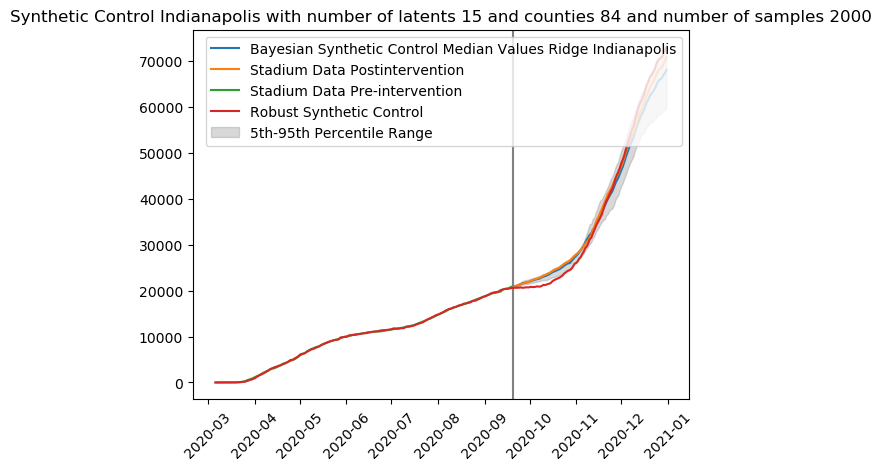

array([20830.89649358, 20905.60327589, 20984.04834958, 21090.23521302,
       21235.44032742, 21380.42448151, 21559.72749316, 21618.0801384 ,
       21709.74045353, 21742.98840234, 21828.34031441, 21942.06182789,
       22074.00278374, 22185.4210689 , 22327.87180676, 22387.57710276,
       22486.63709214, 22558.94339741, 22655.01822032, 22859.73261674,
       23006.39000386, 23116.79331283, 23204.86689567, 23399.58793676,
       23519.38430525, 23761.53114229, 23950.87059119, 24120.45529028,
       24227.93597478, 24396.66602852, 24543.63267938, 24674.97090305,
       24930.76705927, 25136.73737852, 25422.88483309, 25625.32952346,
       25835.69625514, 25941.05669878, 26040.56962805, 26491.07061405,
       26851.14831447, 27245.38448208, 27537.73054914, 27900.69291327,
       28349.13577141, 28758.8512317 , 29298.45020135, 29661.58065317,
       30456.77772828, 31024.05378548, 31559.23393062, 32170.59053436,
       32425.14905401, 33215.71030556, 33576.73414894, 34519.02706456,
      

In [16]:
train_dir = 'dat'

latent_dim_dict = {'Arizona': 5, 'Atlanta':7 , 'Baltimore':15, 'Buffalo':25, 'Carolina': 5, 'Chicago':15, 'Cincinnati':13, 'Cleveland':11, 'Dallas': 37, 'Denver':5 , 'Detroit':12, 'Green Bay': 52, 'Houston': 12, 'Indianapolis': 10, 'Jacksonville':12, 'Kansas City':11, 'Las Vegas':12, 'LA Chargers':5,'LA Rams':10, 'Miami':8, 'Minnesota':5, 'New England': 9, 'New Orleans':18 , 'NY Giants':7,'NY Jets':7, 'Philadelphia':10, 'Pittsburgh': 25, 'San Francisco': 12, 'Seattle': 14, 'Tampa Bay': 15, 'Tennessee': 13, 'Washington':4}

grouped_df = pd.read_csv('Grouped_df.csv')

zipped_input = zip(grouped_df['Team'], grouped_df['County(s)'], grouped_df['State'], grouped_df['First date home stadium open to fans'])

indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_posterior_samples_None_01_latent_dim_5.pth')

#indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_PPOST_None_mask_01_latent_10.pth')



indianapolis_samples = torch.load('/net/projects/schein-lab/jshou/Posterior_Checks/Indianapolis/GAP_posterior_samples_None_01_latent_dim_15.pth')
bayesian_SC_graph(zipped_input)

In [32]:
grouped_df

Unnamed: 0           Team  \
0            0        Arizona   
1            1        Atlanta   
2            2      Baltimore   
3            3        Buffalo   
4            4       Carolina   
5            5        Chicago   
6            6     Cincinnati   
7            7      Cleveland   
8            8         Dallas   
9            9         Denver   
10          10        Detroit   
11          11      Green Bay   
12          12        Houston   
13          13   Indianapolis   
14          14   Jacksonville   
15          15    Kansas City   
16          16    LA Chargers   
17          17        LA Rams   
18          18      Las Vegas   
19          19          Miami   
20          20      Minnesota   
21          21      NY Giants   
22          22        NY Jets   
23          23    New England   
24          24    New Orleans   
25          25   Philadelphia   
26          26     Pittsburgh   
27          27  San Francisco   
28          28        Seattle   
29          29      Tampa Bay   
30          30      Tennessee   
31          31     Washington   

                 First date home stadium open to fans  \
0                                      ['10/25/2020']   
1   ['10/25/2020', '', '', '', '', '', '', '', '',...   
2           ['11/1/2020', '', '', '', '', '', '', '']   
3   ['Post season fans', 'First home', 'game no fa...   
4       ['10/4/2020', '', '', '', '', '', '', '', '']   
5                                       ['9/20/2020']   
6   ['10/4/2020', '', '', '', '', '', '', '', '', ...   
7   ['9/17/2020', '', '', '', '', '', '', '', '', '']   
8   ['9/20/2020', '', '', '', '', '', '', '', '', '']   
9   ['9/27/2020', '', '', '', '', '', '', '', '', ...   
10                                      ['9/13/2020']   
11  ['Post season', '', 'First home', 'game no fan...   
12          ['10/4/2020', '', '', '', '', '', '', '']   
13  ['9/20/2020', '', '', '', '', '', '', '', '', ...   
14      ['9/13/2020', '', '', '', '', '', '', '', '']   
15                                      ['9/10/2020']   
16                                      ['9/13/2020']   
17                                      ['9/13/2020']   
18                                      ['9/21/2020']   
19              ['9/20/2020', '', '', '', '', '', '']   
20                                      ['9/13/2020']   
21                                      ['9/14/2020']   
22                                      ['9/14/2020']   
23                                      ['9/13/2020']   
24                                      ['9/13/2020']   
25  ['10/18/2020', '', '', '', '', '', '', '', '',...   
26                                     ['10/11/2020']   
27                                      ['9/13/2020']   
28                                      ['9/20/2020']   
29          ['10/4/2020', '', '', '', '', '', '', '']   
30                                     ['10/13/2020']   
31                                      ['9/13/2020']   

                                            County(s)  \
0                                        ['maricopa']   
1      ['fulton', '', '', '', '', '', '', '', '', '']   
2   ['baltimore', 'baltimore city', '', '', '', ''...   
3                            ['erie', '', '', '', '']   
4     ['mecklenburg', '', '', '', '', '', '', '', '']   
5                                            ['cook']   
6   ['hamilton', '', '', '', '', '', '', '', '', '...   
7    ['cuyahoga', '', '', '', '', '', '', '', '', '']   
8   ['dallas', 'tarrant', '', '', '', '', '', '', ...   
9   ['denver', 'arapahoe', '', '', '', '', '', '',...   
10                                          ['wayne']   
11  ['brown', '', '', '', '', '', '', '', '', '', ...   
12             ['harris', '', '', '', '', '', '', '']   
13  ['marion', '', '', '', '', '', '', '', '', '',...   
14          ['duval', '', '', '', '', '', '', '', '']   
15     ['johnson', 'jackson', '', '', '', '', '', '']   
16                                    ['los angeles']   
17    